In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

### Geting Data

In [2]:
DATA_DIR = "./archive/"

In [3]:
import os
imagesOS = os.listdir(DATA_DIR+'images')
print(imagesOS[:5])

['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg']


In [4]:
import matplotlib.pyplot as plt
from skimage import io

In [5]:
import numpy as np

In [6]:
def plot_images(r,c,images):
    plt.figure(figsize=(10,8))
    for idx,img in enumerate(images):
        plt.subplot(r,c,idx+1)
        plt.imshow(io.imread(DATA_DIR+'images/'+img))
        plt.axis('off')

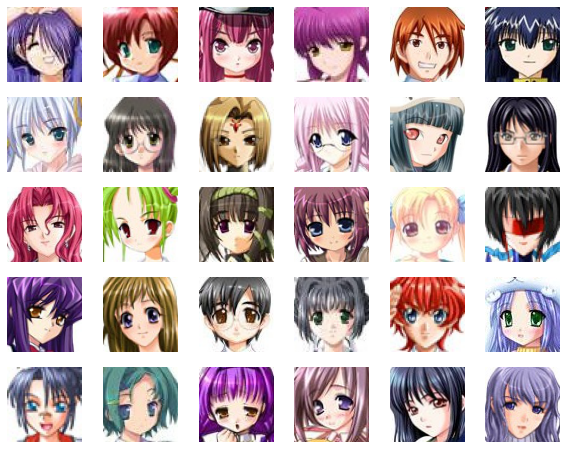

In [7]:
plot_images(5,6,imagesOS[:30])

### Processing Inputs

In [8]:
imageSample = io.imread(DATA_DIR+'images/'+imagesOS[20])

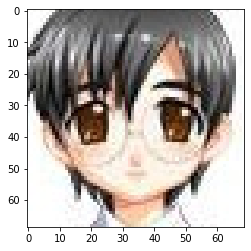

In [9]:
plt.imshow(imageSample)

In [10]:
imageSample.shape

(69, 69, 3)

In [11]:
p = T.Compose([
    T.ToPILImage(),
    T.Resize(64)
])
p

Compose(
    ToPILImage()
    Resize(size=64, interpolation=PIL.Image.BILINEAR)
)

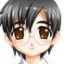

In [12]:
p(imageSample)

In [13]:
p(imageSample).size

(64, 64)

#### Performing more steps at our dataset folder

In [14]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [15]:
train_ds = ImageFolder(DATA_DIR,transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

In [16]:
train_dl = DataLoader(train_ds,batch_size,shuffle=True, num_workers=3, pin_memory=True)

In [17]:
len(train_dl)

497

In [32]:
for img,_ in train_dl:
    print(img.shape)
    break

torch.Size([128, 3, 64, 64])


### Denormalizing and plotting images

In [19]:
from torchvision.utils import make_grid # for shwong images in grid

In [20]:
def denorm(imgTensor):
    return imgTensor*0.5 + 0.5
def showImagesGrid(images,num = 50):
    plt.figure(figsize=(5,10))
    plt.imshow(make_grid(denorm(images.detach()[:num]),nrow=5).permute(1,2,0))
    plt.axis('off')

def showBatch(dl,num = 50):
    for images,_ in dl:
        showImagesGrid(images,num)
        break

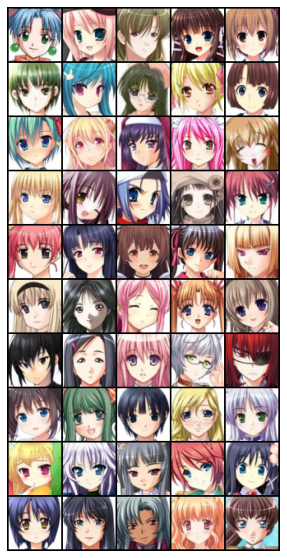

In [21]:
showBatch(train_dl)

### Using GPU

In [22]:
## Checking for gpu
torch.cuda.is_available()

True

In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [24]:
device = get_default_device()
device

device(type='cuda')

In [25]:
train_dl = DeviceDataLoader(train_dl,device)

## Discriminator Network

In [26]:
import torch.nn as nn

In [27]:
discriminator = nn.Sequential(
    #in : 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    #out: 64 x 32 x 32 [(n+2p-f)/s+1]
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
     # out: 128 x 16 x 16
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [28]:
### MOVING our discriminator model to GPU (chosen device)
discriminator = to_device(discriminator,device)

## Generator Network

In [29]:
latent_size = 128

In [30]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

#### Generating and viewing some generated images on random 

In [33]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)

torch.Size([128, 3, 64, 64])


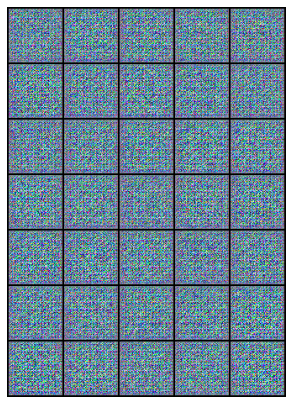

In [34]:
showImagesGrid(fake_images,35)

In [35]:
generator = to_device(generator, device)

## Discriminator Training

In [36]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()
    
    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1,device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate Fake images
    latent = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = generator(latent)
    
    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0),1,device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds,fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(),real_score,fake_score

## Generator Training

In [37]:
def train_generator(opt_g):
    # clear generator gradient
    opt_g.zero_grad()
    
    # Generate Fake images
    latent = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = generator(latent)
    
    # Try to fool discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size,1,device=device)
    loss = F.binary_cross_entropy(preds,targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

#### Utility func to save images

In [38]:
from torchvision.utils import save_image

In [39]:
sample_dir = 'generated'
os.makedirs(sample_dir,exist_ok =True)

In [40]:
def save_samples(index,latent_tensors,show = True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated_images_{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrow = 8)
    print('Saving',fake_fname)
    if show:
        plt.figure(figsize=(8,8))
        plt.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))

In [41]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated_images_0000.png


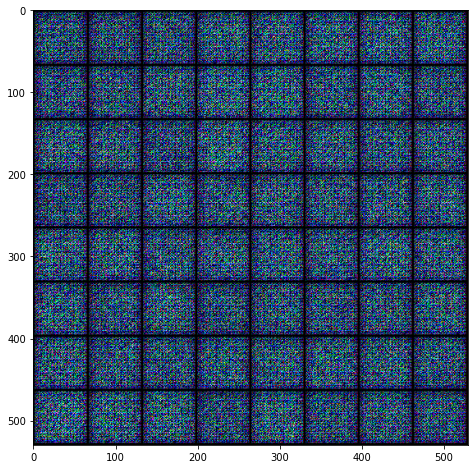

In [42]:
save_samples(0,fixed_latent)

In [43]:
from tqdm.notebook import tqdm # For progress bar
import torch.nn.functional as F

In [44]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [45]:
## Training
lr = 0.0002
epochs = 25

In [46]:
history = fit(epochs,lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 3.7871, loss_d: 0.3028, real_score: 0.8301, fake_score: 0.0700
Saving generated_images_0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 10.0123, loss_d: 0.7409, real_score: 0.9783, fake_score: 0.4912
Saving generated_images_0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 6.6730, loss_d: 0.5652, real_score: 0.9616, fake_score: 0.3650
Saving generated_images_0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 6.5200, loss_d: 0.2804, real_score: 0.9478, fake_score: 0.1855
Saving generated_images_0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 4.3932, loss_d: 0.0433, real_score: 0.9730, fake_score: 0.0117
Saving generated_images_0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 6.4688, loss_d: 0.1035, real_score: 0.9196, fake_score: 0.0092
Saving generated_images_0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 9.4944, loss_d: 0.3402, real_score: 0.9833, fake_score: 0.2460
Saving generated_images_0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 6.3575, loss_d: 0.0893, real_score: 0.9849, fake_score: 0.0674
Saving generated_images_0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 5.6483, loss_d: 0.1242, real_score: 0.9490, fake_score: 0.0528
Saving generated_images_0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 6.5526, loss_d: 0.0197, real_score: 0.9860, fake_score: 0.0040
Saving generated_images_0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 10.8067, loss_d: 0.2742, real_score: 0.9726, fake_score: 0.1876
Saving generated_images_0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 6.1198, loss_d: 0.0620, real_score: 0.9625, fake_score: 0.0193
Saving generated_images_0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 6.8046, loss_d: 0.0957, real_score: 0.9667, fake_score: 0.0522
Saving generated_images_0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 6.4865, loss_d: 0.0283, real_score: 0.9889, fake_score: 0.0165
Saving generated_images_0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 5.8419, loss_d: 0.1052, real_score: 0.9593, fake_score: 0.0495
Saving generated_images_0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 19.8930, loss_d: 0.4570, real_score: 0.9995, fake_score: 0.2670
Saving generated_images_0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 8.6569, loss_d: 0.0876, real_score: 0.9920, fake_score: 0.0695
Saving generated_images_0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 5.0153, loss_d: 0.1075, real_score: 0.9357, fake_score: 0.0263
Saving generated_images_0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 7.3371, loss_d: 0.0330, real_score: 0.9882, fake_score: 0.0197
Saving generated_images_0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 10.4510, loss_d: 0.0319, real_score: 0.9717, fake_score: 0.0009
Saving generated_images_0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 7.3325, loss_d: 0.0299, real_score: 0.9915, fake_score: 0.0207
Saving generated_images_0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 5.2304, loss_d: 0.0470, real_score: 0.9714, fake_score: 0.0153
Saving generated_images_0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 6.5221, loss_d: 0.0808, real_score: 0.9665, fake_score: 0.0232
Saving generated_images_0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 4.8808, loss_d: 0.0981, real_score: 0.9554, fake_score: 0.0465
Saving generated_images_0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 5.0168, loss_d: 0.0804, real_score: 0.9422, fake_score: 0.0127
Saving generated_images_0025.png


In [47]:
ses_g, losses_d, real_scores, fake_scores = history

In [48]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

### Generated images

In [53]:
from IPython.display import Image

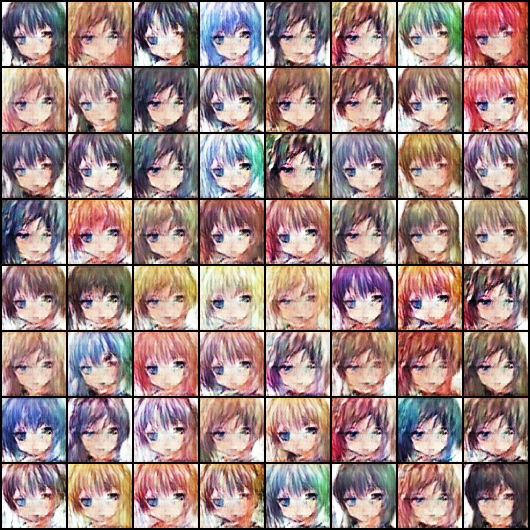

In [54]:
Image('./generated/generated_images_0010.png')

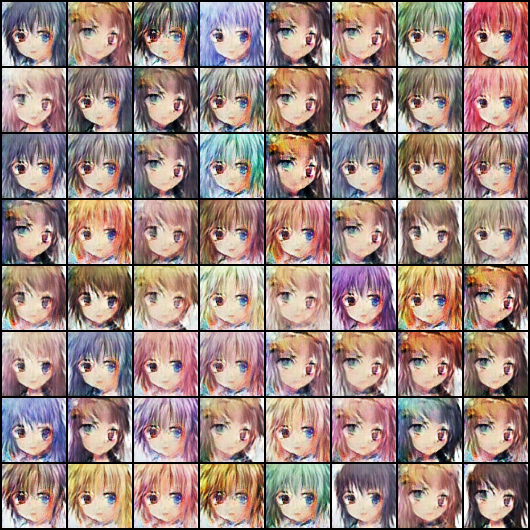

In [56]:
Image('./generated/generated_images_0015.png')

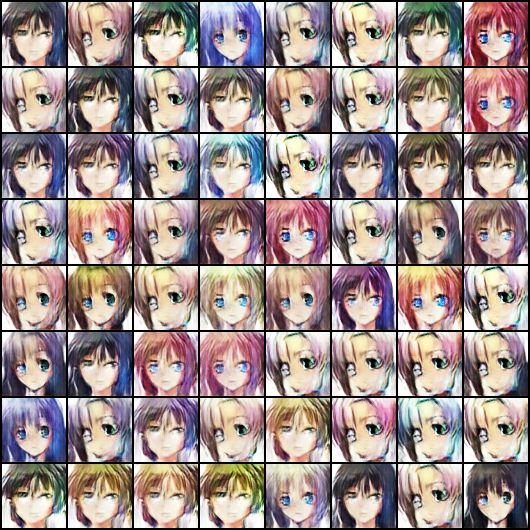

In [55]:
Image('./generated/generated_images_0025.png')

# END